In [220]:
import pandas as pd

# Đọc dữ liệu từ file CSV đã tải lên
file_path = "filtered_data_northern_vietnam.csv"
df = pd.read_csv(file_path)

# Hiển thị một số dòng đầu để kiểm tra dữ liệu
df.head()


,Unnamed: 0,DATE,STATION,TMAX,TMIN,TAVG,PRCP,YEAR,MONTH,SEASON
0,4051,2013-01-01,VMM00048840,61,54,59,0.00,2013,1,Winter
1,4052,2013-01-04,VMM00048840,59,54,56,0.00,2013,1,Winter
2,4053,2013-01-05,VMM00048840,56,52,54,0.01,2013,1,Winter
3,4054,2013-01-06,VMM00048840,54,52,53,0.05,2013,1,Winter
4,4055,2013-01-07,VMM00048840,57,53,55,0.00,2013,1,Winter


In [221]:
# Chuyển đổi nhiệt độ từ độ F sang độ C
df['TMAX'] = round((df['TMAX'] - 32) / 1.8, 1)
df['TMIN'] = round((df['TMIN'] - 32) / 1.8, 1)
df['TAVG'] = round((df['TAVG'] - 32) / 1.8, 1)
df

,Unnamed: 0,DATE,STATION,TMAX,TMIN,TAVG,PRCP,YEAR,MONTH,SEASON
0,4051,2013-01-01,VMM00048840,16.1,12.2,15.0,0.00,2013,1,Winter
1,4052,2013-01-04,VMM00048840,15.0,12.2,13.3,0.00,2013,1,Winter
2,4053,2013-01-05,VMM00048840,13.3,11.1,12.2,0.01,2013,1,Winter
3,4054,2013-01-06,VMM00048840,12.2,11.1,11.7,0.05,2013,1,Winter
4,4055,2013-01-07,VMM00048840,13.9,11.7,12.8,0.00,2013,1,Winter
...,...,...,...,...,...,...,...,...,...,...
7613,28657,2024-09-11,VMM00048806,27.2,21.1,22.8,0.00,2024,9,Autumn
7614,28658,2024-09-12,VMM00048806,27.8,20.6,23.9,0.00,2024,9,Autumn
7615,28659,2024-09-14,VMM00048806,28.9,21.1,24.4,0.00,2024,9,Autumn
7616,28660,2024-09-15,VMM00048806,31.7,20.6,26.1,0.00,2024,9,Autumn


In [222]:
# Xác định các mùa dựa trên MONTH (nếu chưa có SEASON)
if 'SEASON' not in df.columns:
    conditions = [
        df['MONTH'].isin([2, 3, 4]),  # Xuân
        df['MONTH'].isin([5, 6, 7]),  # Hạ
        df['MONTH'].isin([8, 9, 10]),  # Thu
        df['MONTH'].isin([11, 12, 1])  # Đông
    ]
    seasons = ['Spring', 'Summer', 'Autumn', 'Winter']
    df['SEASON'] = pd.Series(seasons).iloc[pd.concat([pd.Series(c) for c in conditions], axis=1).idxmax(axis=1)].values
    df


In [223]:

# Tính nhiệt độ trung bình, tối đa, tối thiểu theo mùa từng năm
seasonal_stats = df.groupby(['YEAR', 'SEASON']).agg(
    TAVG_mean=('TAVG', 'mean'),
    TMAX_max=('TMAX', 'max'),
    TMIN_min=('TMIN', 'min'),
    TEMP_range=('TAVG', lambda x: x.max() - x.min())
).reset_index()

# Làm tròn các giá trị
seasonal_stats = seasonal_stats.round(1)
seasonal_stats.head()


,YEAR,SEASON,TAVG_mean,TMAX_max,TMIN_min,TEMP_range
0,2013,Autumn,25.8,37.2,11.1,13.3
1,2013,Spring,22.2,35.6,8.3,18.8
2,2013,Summer,27.6,39.4,16.1,12.7
3,2013,Winter,16.7,32.2,1.1,21.1
4,2014,Autumn,26.6,37.8,14.4,12.2


In [224]:
# Hàm xác định giá trị nhiệt độ cực đoan (outliers) theo mùa
def calculate_seasonal_outliers(df, column):
    df['IS_OUTLIER'] = False  # Cột mặc định là False
    for (year, season), group in df.groupby(['YEAR', 'SEASON']):
        q1 = group[column].quantile(0.25)
        q3 = group[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = (group[column] < lower_bound) | (group[column] > upper_bound)
        df.loc[(df['YEAR'] == year) & (df['SEASON'] == season) & outliers, 'IS_OUTLIER'] = True
    return df


In [225]:
# Xác định tần suất xuất hiện nhiệt độ cực đoan theo mùa
df = calculate_seasonal_outliers(df, 'TAVG')
extreme_temp_counts = df[df['IS_OUTLIER']].groupby(['YEAR', 'SEASON']).size().reset_index(name='extreme_count')

# Kết hợp với bảng seasonal_stats
seasonal_stats = seasonal_stats.merge(extreme_temp_counts, on=['YEAR', 'SEASON'], how='left')
seasonal_stats['extreme_count'] = seasonal_stats['extreme_count'].fillna(0).astype(int)



In [226]:
season_order = ["Spring", "Summer", "Autumn", "Winter"]
df['SEASON'] = pd.Categorical(df['SEASON'], categories=season_order, ordered=True)


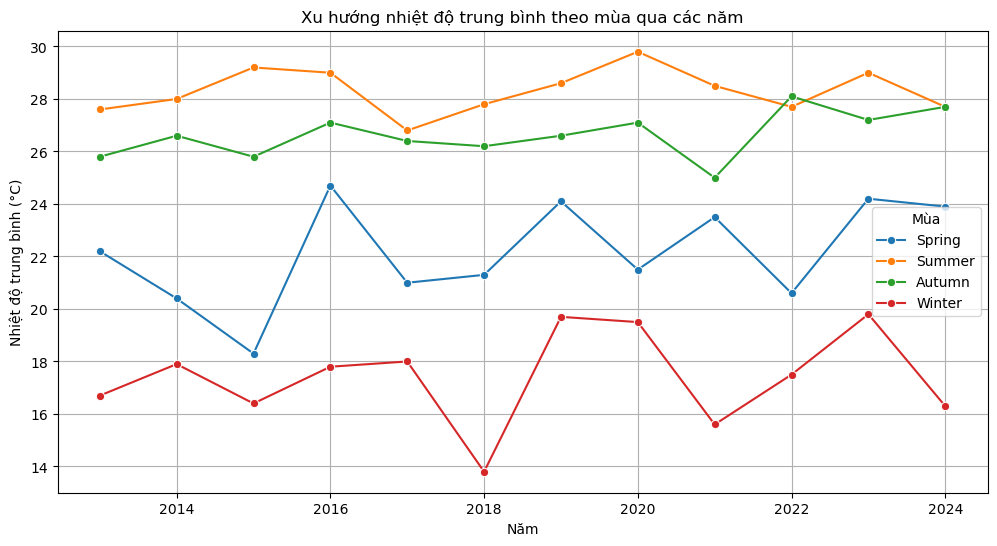

In [227]:

# Vẽ các biểu đồ phân tích xu hướng
import matplotlib.pyplot as plt
import seaborn as sns

# Biểu đồ 1: Xu hướng nhiệt độ trung bình theo mùa qua các năm
plt.figure(figsize=(12, 6))
sns.lineplot(data=seasonal_stats, x='YEAR', y='TAVG_mean', hue='SEASON', marker='o', hue_order=season_order)
plt.title('Xu hướng nhiệt độ trung bình theo mùa qua các năm')
plt.xlabel('Năm')
plt.ylabel('Nhiệt độ trung bình (°C)')
plt.legend(title='Mùa')
plt.grid(True)
plt.show()


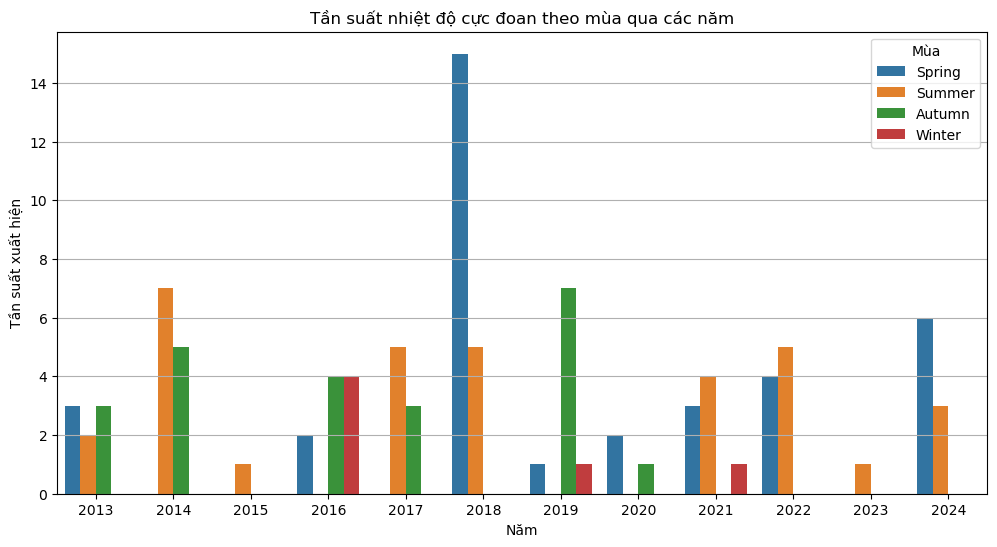

In [228]:
# Biểu đồ 2: So sánh tần suất nhiệt độ cực đoan giữa các mùa
plt.figure(figsize=(12, 6))
sns.barplot(data=seasonal_stats, x='YEAR', y='extreme_count', hue='SEASON', hue_order=season_order)
plt.title('Tần suất nhiệt độ cực đoan theo mùa qua các năm')
plt.xlabel('Năm')
plt.ylabel('Tần suất xuất hiện')
plt.legend(title='Mùa')
plt.grid(axis='y')
plt.show()


C:\Users\WIN 10\AppData\Local\Temp\ipykernel_2896\3667947743.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=seasonal_stats, x='SEASON', y='TEMP_range', palette='coolwarm', order=season_order)


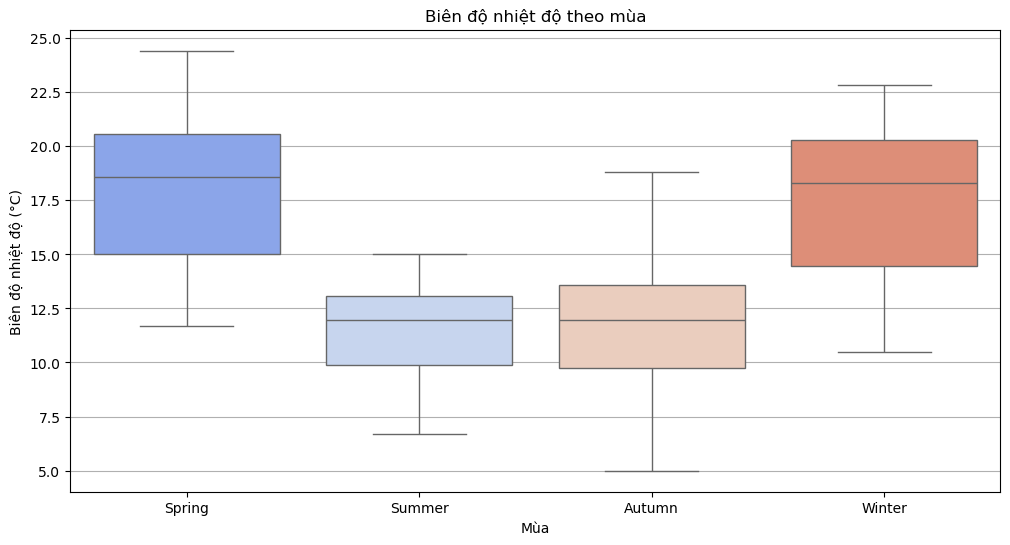

In [229]:

# Biểu đồ 3: So sánh biên độ nhiệt độ giữa các mùa
plt.figure(figsize=(12, 6))
sns.boxplot(data=seasonal_stats, x='SEASON', y='TEMP_range', palette='coolwarm', order=season_order)
plt.title('Biên độ nhiệt độ theo mùa')
plt.xlabel('Mùa')
plt.ylabel('Biên độ nhiệt độ (°C)')
plt.grid(axis='y')
plt.show()

In [230]:
import numpy as np
from scipy.stats import linregress

# Tính xu hướng nhiệt độ theo từng mùa
def calculate_trend(data, season):
    seasonal_data = data[data['SEASON'] == season]
    if len(seasonal_data) > 1:  # Chỉ thực hiện nếu có đủ dữ liệu
        slope, intercept, r_value, p_value, std_err = linregress(seasonal_data['YEAR'], seasonal_data['TAVG_mean'])
        return slope  # Trả về độ dốc (slope) của hồi quy
    return np.nan

# Tính độ dốc xu hướng cho từng mùa
seasonal_trends = seasonal_stats.groupby('SEASON').apply(lambda x: calculate_trend(x, x.name)).reset_index(name='TAVG_trend')
seasonal_trends = seasonal_trends.dropna()  # Loại bỏ mùa không đủ dữ liệu
print("Xu hướng nhiệt độ trung bình theo mùa (°C/năm):")
print(seasonal_trends)



Xu hướng nhiệt độ trung bình theo mùa (°C/năm):
   SEASON  TAVG_trend
0  Autumn    0.120280
1  Spring    0.235315
2  Summer    0.024126
3  Winter    0.069231


C:\Users\WIN 10\AppData\Local\Temp\ipykernel_2896\2700719359.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  seasonal_trends = seasonal_stats.groupby('SEASON').apply(lambda x: calculate_trend(x, x.name)).reset_index(name='TAVG_trend')


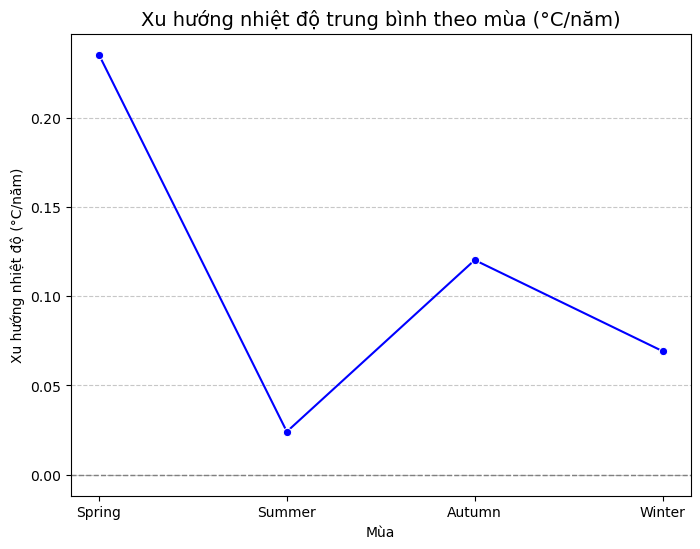

In [231]:
season_order = ['Spring', 'Summer', 'Autumn', 'Winter']
seasonal_trends['SEASON'] = pd.Categorical(
    seasonal_trends['SEASON'], 
    categories=season_order, 
    ordered=True
)
# Vẽ biểu đồ đường cho xu hướng nhiệt độ trung bình
plt.figure(figsize=(8, 6))

# Duyệt qua từng nhóm liên tục (không có khoảng trống giữa các mùa)
for _, group in seasonal_trends.dropna(subset=['TAVG_trend']).groupby((seasonal_trends['TAVG_trend'].isna()).cumsum()):
    sns.lineplot(
        data=group,
        x='SEASON',
        y='TAVG_trend',
        marker='o',
        color='b'
    )

# Thêm các thiết lập khác cho biểu đồ
plt.title("Xu hướng nhiệt độ trung bình theo mùa (°C/năm)", fontsize=14)
plt.xlabel("Mùa")
plt.ylabel("Xu hướng nhiệt độ (°C/năm)")
plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # Đường tham chiếu tại 0
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



C:\Users\WIN 10\AppData\Local\Temp\ipykernel_2896\977246029.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lambda x: x.groupby('SEASON')['TAVG'].mean().max() - x.groupby('SEASON')['TAVG'].mean().min()
C:\Users\WIN 10\AppData\Local\Temp\ipykernel_2896\977246029.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_season_diff = df.groupby('YEAR').apply(


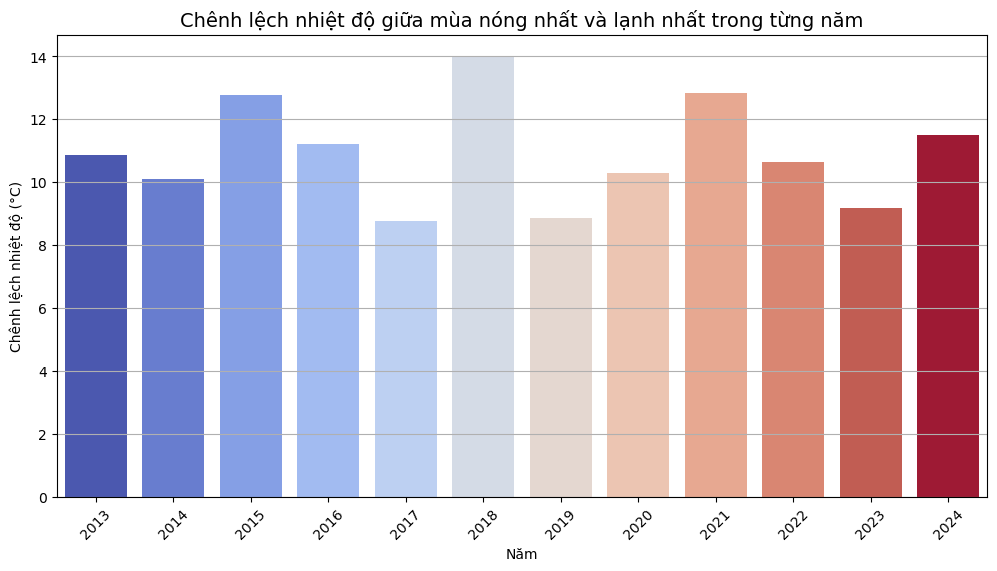

In [232]:
# Tính chênh lệch nhiệt độ giữa mùa nóng nhất và lạnh nhất trong cùng năm
yearly_season_diff = df.groupby('YEAR').apply(
    lambda x: x.groupby('SEASON')['TAVG'].mean().max() - x.groupby('SEASON')['TAVG'].mean().min()
).reset_index(name='Temp_Diff_Yearly')

# Vẽ biểu đồ cột chênh lệch nhiệt độ theo từng năm
plt.figure(figsize=(12, 6))
sns.barplot(
    data=yearly_season_diff,
    x='YEAR',
    y='Temp_Diff_Yearly',
    hue='YEAR',  # Thêm 'YEAR' làm hue
    palette='coolwarm',
    dodge=False  # Đảm bảo không chia các cột
)
plt.legend([], [], frameon=False)  # Loại bỏ chú thích
plt.title("Chênh lệch nhiệt độ giữa mùa nóng nhất và lạnh nhất trong từng năm", fontsize=14)
plt.xlabel("Năm")
plt.ylabel("Chênh lệch nhiệt độ (°C)")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


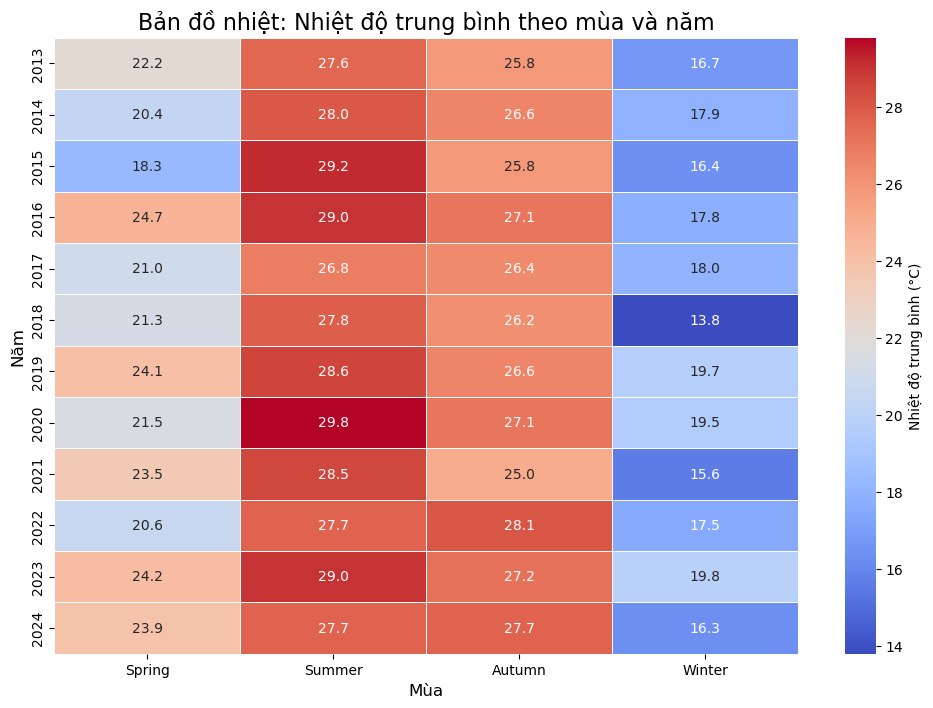

In [233]:

# Tạo bảng nhiệt độ trung bình (TAVG_mean) theo mùa và năm
heatmap_data = seasonal_stats.pivot(index="YEAR", columns="SEASON", values="TAVG_mean")

# Vẽ heatmap
plt.figure(figsize=(12, 8))
heatmap_data = seasonal_stats.pivot(index="YEAR", columns="SEASON", values="TAVG_mean").reindex(columns=season_order)
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="coolwarm", linewidths=0.5, cbar_kws={"label": "Nhiệt độ trung bình (°C)"})
plt.title("Bản đồ nhiệt: Nhiệt độ trung bình theo mùa và năm", fontsize=16)
plt.xlabel("Mùa", fontsize=12)
plt.ylabel("Năm", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()  

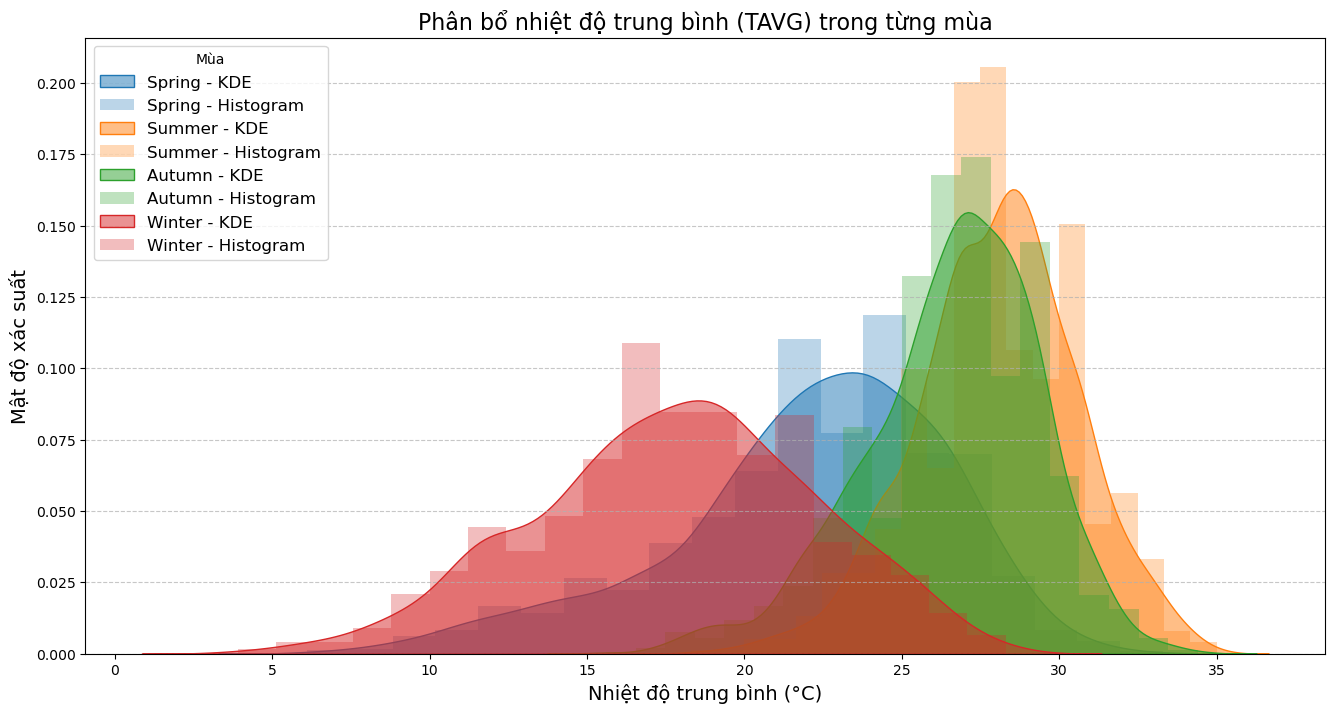

In [234]:
# Vẽ biểu đồ phân bổ nhiệt độ (KDE và histogram) cho từng mùa
plt.figure(figsize=(16, 8))

# Lặp qua từng mùa trong danh sách đã sắp xếp
for season in season_order:
    # Dữ liệu nhiệt độ trung bình (TAVG) của từng mùa
    season_data = df[df['SEASON'] == season]['TAVG']
    
    # Vẽ biểu đồ KDE (đường cong phân phối xác suất)
    sns.kdeplot(season_data, label=f"{season} - KDE", fill=True, alpha=0.5)
    
    # Vẽ histogram (tần suất)
    plt.hist(season_data, bins=20, alpha=0.3, label=f"{season} - Histogram", density=True)

# Thiết lập các thông số cho biểu đồ
plt.title("Phân bổ nhiệt độ trung bình (TAVG) trong từng mùa", fontsize=16)
plt.xlabel("Nhiệt độ trung bình (°C)", fontsize=14)
plt.ylabel("Mật độ xác suất", fontsize=14)
plt.legend(title="Mùa", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


C:\Users\WIN 10\AppData\Local\Temp\ipykernel_2896\4239560547.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  season_corr = df.groupby('SEASON').apply(lambda x: x[['TAVG', 'PRCP']].corr().iloc[0, 1]).reset_index(name='Correlation')
C:\Users\WIN 10\AppData\Local\Temp\ipykernel_2896\4239560547.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  season_corr = df.groupby('SEASON').apply(lambda x: x[['TAVG', 'PRCP']].corr().iloc[0, 1]).reset_index(name='Correlation')


Tương quan giữa nhiệt độ và lượng mưa theo mùa:
   SEASON  Correlation
0  Spring    -0.082922
1  Summer    -0.265610
2  Autumn    -0.070154
3  Winter    -0.087993


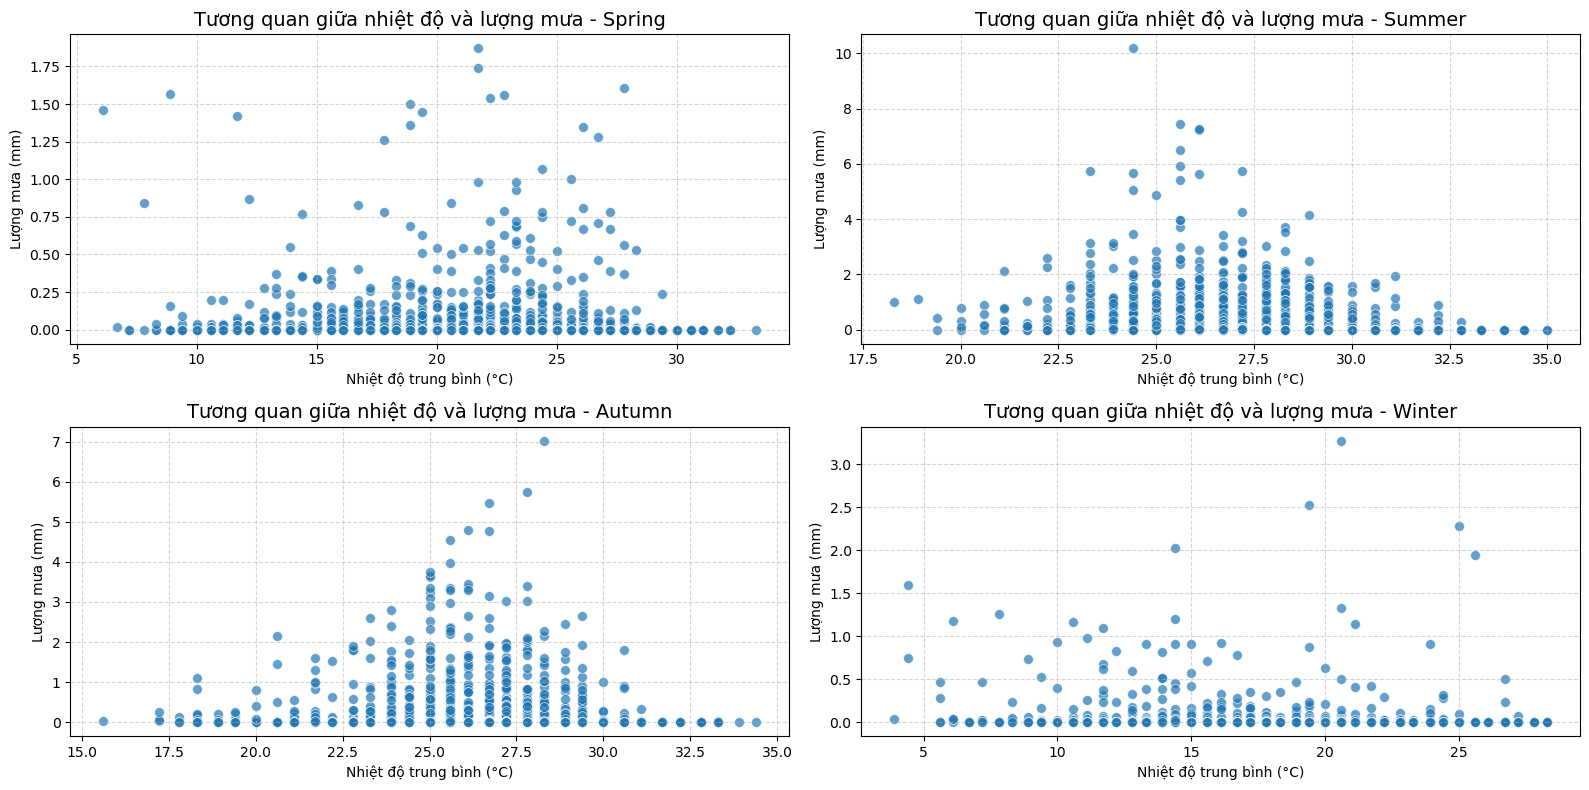

C:\Users\WIN 10\AppData\Local\Temp\ipykernel_2896\4239560547.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=season_corr, x='SEASON', y='Correlation', palette='coolwarm', order=season_order)


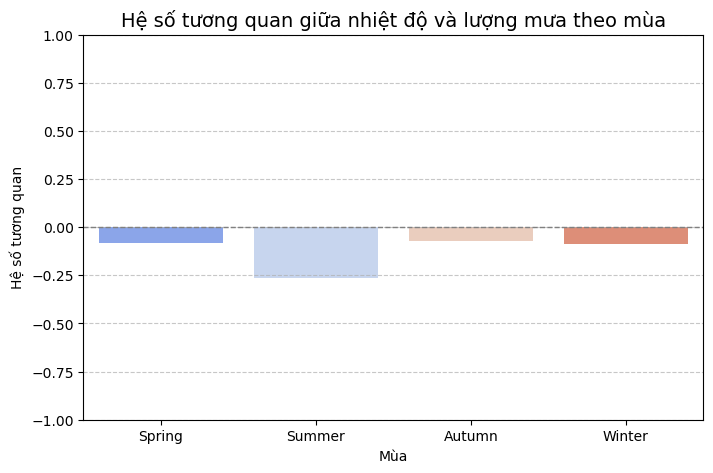

In [ ]:
# Tính tương quan giữa TAVG và PRCP theo mùa
season_corr = df.groupby('SEASON').apply(lambda x: x[['TAVG', 'PRCP']].corr().iloc[0, 1]).reset_index(name='Correlation')

# Hiển thị bảng tương quan
print("Tương quan giữa nhiệt độ và lượng mưa theo mùa:")
print(season_corr)

# Vẽ biểu đồ phân tán (scatterplot) giữa TAVG và PRCP theo mùa
plt.figure(figsize=(16, 8))
for i, season in enumerate(season_order, 1):
    # Lấy dữ liệu theo mùa
    season_data = df[df['SEASON'] == season]
    
    # Vẽ biểu đồ scatter
    plt.subplot(2, 2, i)
    sns.scatterplot(data=season_data, x='TAVG', y='PRCP', alpha=0.7, s=50)
    plt.title(f"Tương quan giữa nhiệt độ và lượng mưa - {season}", fontsize=14)
    plt.xlabel("Nhiệt độ trung bình (°C)")
    plt.ylabel("Lượng mưa (mm)")
    plt.grid(True, linestyle="--", alpha=0.5)

# Điều chỉnh khoảng cách giữa các biểu đồ
plt.tight_layout()
plt.show()

# Vẽ biểu đồ thanh hiển thị giá trị tương quan theo mùa
plt.figure(figsize=(8, 5))
sns.barplot(data=season_corr, x='SEASON', y='Correlation', palette='coolwarm', order=season_order)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # Đường tham chiếu tại 0
plt.title("Hệ số tương quan giữa nhiệt độ và lượng mưa theo mùa", fontsize=14)
plt.xlabel("Mùa")
plt.ylabel("Hệ số tương quan")
plt.ylim(-1, 1)  # Giới hạn hệ số tương quan
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
